DJESSOU REGISTE - HEIDARI SHAHIN - TOUKAM KEVIN XAVIER
Bienvenue sur notre projet de **Chatbot**!
Notre chatbot copiera les données depuis [ ce site](https://www.whatishumanresource.com/human-resource-management). Ces données contiennent tout ce qui a rapport à la gestion des ressources humaines. Notre chatbot aura aussi la possibilité de prendre les données depuis wikipedia. 

In [1]:
pip install wikipedia

Note: you may need to restart the kernel to use updated packages.


Importons toutes les librairies dont on aura besoin

In [2]:
import nltk
import random
import string
import re, string, unicodedata
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import wikipedia as wk
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\regis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\regis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\regis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Ensuite nous allons chargé les données récupéré sur notre site et les convertir en minuscule pour que le traitement soit plus simple. 

In [3]:
data = open('data.txt',errors = 'ignore')
raw = data.read()
raw = raw.lower()

Nous pouvons vérifier le contenue de notre fichier si il est bien chargé.

In [ ]:
raw[:1000]

Ensuite convertissons les données en liste de phrases pour le traitement. 

In [4]:
sent_tokens = nltk.sent_tokenize(raw)

Vous pouvez vérifier le contenu

In [ ]:
print(sent_tokens)

Ensuite nous allons normaliser les données en séquences plus uniformes. Cette étape comprend la tokénisation des mots, la suppression des valeurs ASCII, la suppression des balises de toute sorte.

In [5]:
def Normalize(text):
    remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
    #word tokenization
    word_token = nltk.word_tokenize(text.lower().translate(remove_punct_dict))
    
    #remove ascii
    new_words = []
    for word in word_token:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    
    #Remove tags
    rmv = []
    for w in new_words:
        text=re.sub("&lt;/?.*?&gt;","&lt;&gt;",w)
        rmv.append(text)
        
    #pos tagging and lemmatization
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    lmtzr = WordNetLemmatizer()
    lemma_list = []
    rmv = [i for i in rmv if i]
    for token, tag in nltk.pos_tag(rmv):
        lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
        lemma_list.append(lemma)
    return lemma_list

Nos données étant pret, définissons des expressions d'acceuil pour notre robot au cas ou on le saluera. Du coup on selectionne une salutation au hasard pour répondre à une salutation. 

In [6]:
welcome_input = ("hello", "hi", "greetings", "sup", "what's up","hey",)
welcome_response = ["hi", "hey", "*nods*", "hi there", "hello", "I am glad! You are talking to me"]
def welcome(user_response):
    for word in user_response.split():
        if word.lower() in welcome_input:
            return random.choice(welcome_response)

Générer une réponse du chatbot

Pour générer une réponse de notre chatbot aux questions entrées, le concept de similarité des documents sera utilisé. Le vectoriseur TFidf est utilisé pour convertir une collection de documents bruts en une matrice de caractéristiques TF-IDF et pour trouver la similarité entre les mots entrés par l'utilisateur et les mots du jeu de données, nous utiliserons la similarité en cosinus. 

Nous définissons une fonction generateResponse() qui recherche les mots saisis par l'utilisateur et renvoie une réponse parmi plusieurs possibles. Si l'entrée ne correspond à aucun des mots clés, vous pouvez demander à votre chatbot d'effectuer une recherche sur Wikipédia à votre place, au lieu d'envoyer un message d'erreur. Tapez simplement "tell me about any_keyword". Maintenant, s'il ne trouve rien dans Wikipedia, le chatbot générera un message No content has been found". 


In [7]:
def generateResponse(user_response):
    robo_response=''
    sent_tokens.append(user_response)
    TfidfVec = TfidfVectorizer(tokenizer=Normalize, stop_words='english')
    tfidf = TfidfVec.fit_transform(sent_tokens)
    #vals = cosine_similarity(tfidf[-1], tfidf)
    vals = linear_kernel(tfidf[-1], tfidf)
    idx=vals.argsort()[0][-2]
    flat = vals.flatten()
    flat.sort()
    req_tfidf = flat[-2]
    if(req_tfidf==0) or "tell me about" in user_response:
        print("Checking Wikipedia")
        if user_response:
            robo_response = wikipedia_data(user_response)
            return robo_response
    else:
        robo_response = robo_response+sent_tokens[idx]
        return robo_response#wikipedia search

def wikipedia_data(input):
    reg_ex = re.search('tell me about (.*)', input)
    try:
        if reg_ex:
            topic = reg_ex.group(1)
            wiki = wk.summary(topic, sentences = 3)
            return wiki
    except Exception as e:
            print("No content has been found")

Ensuite nous définissons une fonction pour définir le fonctionnement de notre application

In [8]:
def chatbot_response(user_response):
    result = ""
    flag=True
    print("My name is Chatterbot and I'm a chatbot. If you want to exit, type Bye!")
    while(flag==True):
        #user_response = input()
        user_response=user_response.lower()
        if(user_response not in ['bye','shutdown','exit', 'quit']):
            if(user_response=='thanks' or user_response=='thank you' ):
                flag=False
                result = "Chatterbot : You are welcome.."
            else:
                if(welcome(user_response)!=None):
                    result = "Chatterbot : "+welcome(user_response)
                else:
                    print("Chatterbot : ",end="")
                    result = generateResponse(user_response)
                    sent_tokens.remove(user_response)
        else:
            flag=False
            result = "Chatterbot : Bye!!! "
            
        return result;
            

Nous allons maintenant definir une fonction qui pourra recupérer les données d'entrées et la réponse du chatbot pour qu'il soit afficher sur notre interface. 

In [9]:
def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)

    if msg != '':
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground="#442265", font=("Verdana", 12 ))

        res = chatbot_response(msg)
        ChatLog.insert(END, "Bot: " + res + '\n\n')

        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)

Ici on défini notre programme et notre interface.
Excutez le programme sur votre machine physique, sur google collab l'interface ne pourra pas s'executer. 

In [16]:
#Creating GUI with tkinter
import tkinter
from tkinter import *        
        

base = Tk()
base.title("Hello")
base.geometry("400x500")
base.resizable(width=FALSE, height=FALSE)

#Create Chat window
ChatLog = Text(base, bd=0, bg="white", height="8", width="50", font="Arial",)

ChatLog.config(state=DISABLED)

#Bind scrollbar to Chat window
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="heart")
ChatLog['yscrollcommand'] = scrollbar.set

#Create Button to send message
SendButton = Button(base, font=("Verdana",12,'bold'), text="Send", width="12", height=5,
                    bd=0, bg="#32de97", activebackground="#3c9d9b",fg='#ffffff',
                    command= send )

#Create the box to enter message
EntryBox = Text(base, bd=0, bg="white",width="29", height="5", font="Arial")
#EntryBox.bind("<Return>", send)


#Place all components on the screen
scrollbar.place(x=376,y=6, height=386)
ChatLog.place(x=6,y=6, height=386, width=370)
EntryBox.place(x=128, y=401, height=90, width=265)
SendButton.place(x=6, y=401, height=90)

base.mainloop()

My name is Chatterbot and I'm a chatbot. If you want to exit, type Bye!
Chatterbot : Checking Wikipedia


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\regis\anaconda3\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-9-1cd93491acca>", line 11, in send
    ChatLog.insert(END, "Bot: " + res + '\n\n')
TypeError: can only concatenate str (not "NoneType") to str


My name is Chatterbot and I'm a chatbot. If you want to exit, type Bye!
Chatterbot : Checking Wikipedia


Essayons notre bot

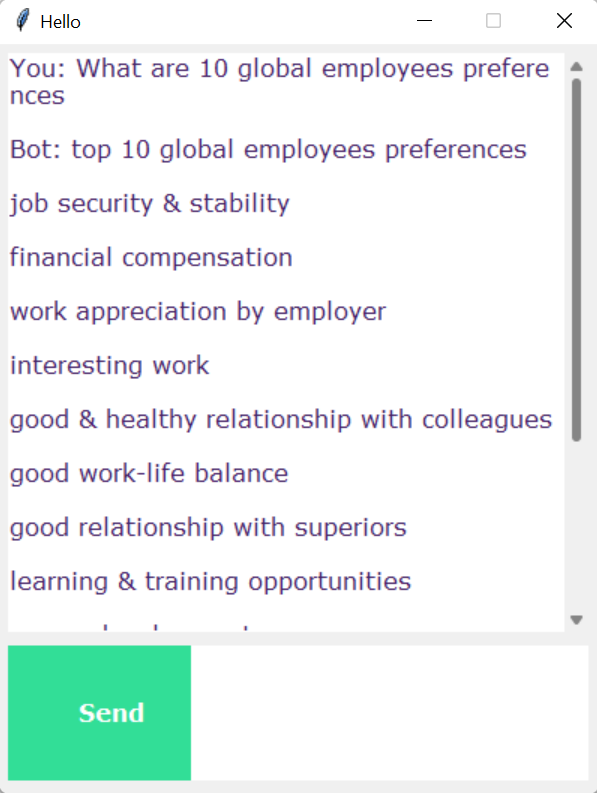

In [13]:
from IPython.display import Image
Image("imgbot1.png")

Nous pouvons voir qu'il marche parfaitement. Nous pouvons lui demander aussi de chercher sur wikipedia

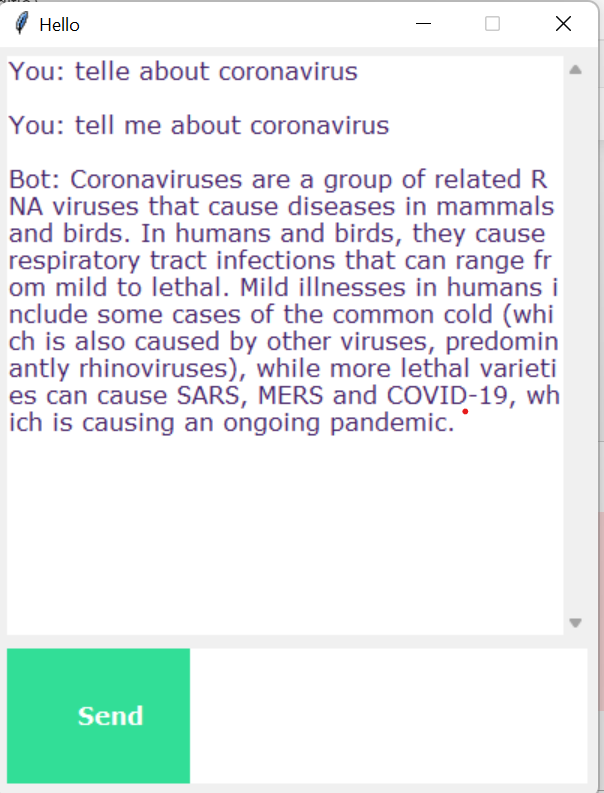

In [18]:
from IPython.display import Image
Image("imgbot2.png")